# Titanic Binary Classification (타이타닉 생존자 예측)

> 타이타닉 탑승 승객의 정보(data)를 바탕으로 그들이 생존했는지를 예측하는 이진 분류 문제  
> 주요 핵심은 model, preprocessing and feature engineering

In [1]:
# library 불러오기
import numpy as np 
import pandas as pd 
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Load

> 처음에는 train 데이터를 불러온 뒤, 기본 정보와 결측치 여부, 레이블 분포 등을 확인함.  
> 각 feature를 하나하나 뜯어보며 어떻게 변형할 수 있을지 전략을 세움.

데이터를 불러온 후 상위 행을 출력해서 변수 확인

In [2]:
#Load the dataset
data=pd.read_csv("data/train.csv",index_col="PassengerId")
y=data["Survived"]
X=data.drop(labels=["Survived"], axis=1)

In [ ]:
# 입력 데이터의 형태 살펴보기
print('number of data inputs = ',len(X.index))
X.head()

number of data inputs =  891


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


레이블의 상위 몇 개 값도 함께 확인

In [4]:
y.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

여기서 1은 생존, 0은 사망을 의미함

데이터 타입과 결측치 개수를 확인함

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


각 feature를 하나씩 보고 전처리를 진행

## Feature engineering
>- data를 model에 넣기 전에 각 column들을 분석하고 변환하는 과정.  
>- 특히 범주형 변수 처리, 파생 변수 생성, 스케일링 등이 포함됨.

### Pclass (객실 등급)
>- ticket 등급을 의미하는 column. 
>- 숫자처럼 보이지만 실제로는 category 개념이 강함 → One-hot encoding으로 변환.
>- Pclass는 1, 2, 3의 값을 가지며 객실 등급을 나타냄

In [6]:
X.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [7]:
oh= pd.get_dummies(X.Pclass,prefix="Pclass")
X = X.drop(labels='Pclass',axis=1).join(oh)

### Name
>- Name 컬럼은 직접 사용하지 않지만, 그 안의 title 정보는 유용.  
>- 이름에서 의미 있는 정보는 호칭(title)로 판단하여 이를 추출함
>- Mr, Mrs, Miss 등 호칭을 추출해서 새로운 feature로 사용.

In [ ]:
X['Title'] = X.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
pd.crosstab(X.Title, X.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


희귀한 title은 Rare로 묶고, 비슷한 것끼리는 합침

In [9]:
rare_titles = ['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady',
           'Major', 'Rev', 'Sir']

X.Title.replace(rare_titles, 'Rare', inplace = True)
X.Title.replace(['Mlle', 'Ms'], 'Miss', inplace = True)
X.Title.replace(['Mme'], 'Mrs', inplace = True)
pd.crosstab(X.Title, X.Sex)

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


<Axes: xlabel='Title', ylabel='count'>

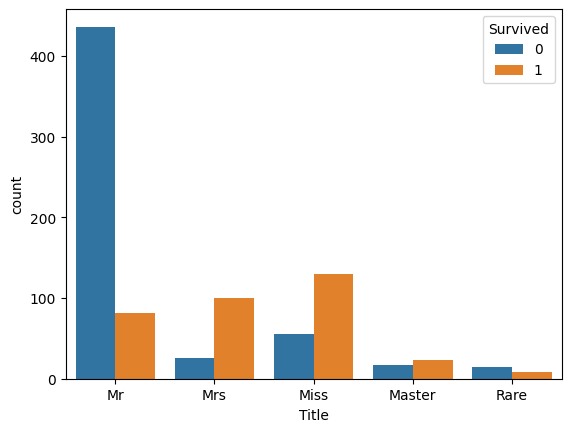

In [10]:
sns.countplot(x=X.Title,hue=data.Survived)

In [11]:
oh= pd.get_dummies(X.Title,prefix="Title")
X = X.drop(labels=['Name','Title'],axis=1).join(oh)
#X.Name = (X.Name.str.contains('Mr.')|X.Name.str.contains('Mrs.')).astype(np.uint8)

### Sex

>단 두 개의 값만 존재하므로 이진 인코딩 처리함.  
>* 여성을 1, 남성을 0으로 처리함.

In [12]:
X.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [13]:
X.Sex= (X.Sex=='female').astype(np.uint8)

<Axes: xlabel='Sex', ylabel='count'>

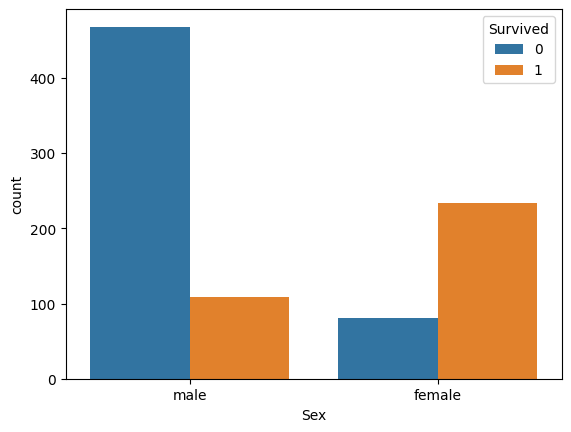

In [14]:
sns.countplot(data=data,x='Sex',hue="Survived")

### Age(나이)

<Axes: xlabel='Age', ylabel='Density'>

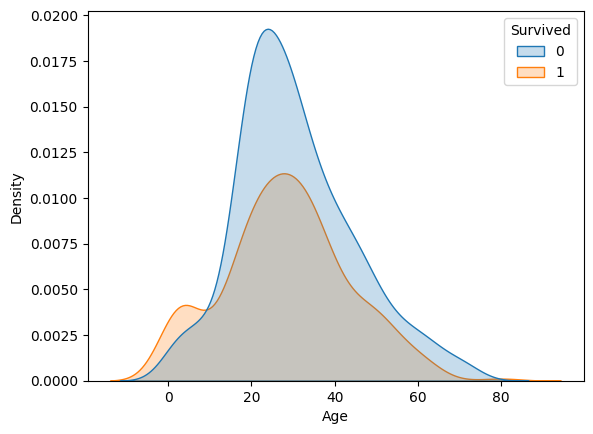

In [15]:
# Age와 Survived를 하나의 DataFrame으로 묶기
df_plot = pd.DataFrame({
    "Age": X["Age"],
    "Survived": y
})

# kdeplot 그리기 (fill=True는 shade=True의 최신 옵션)
sns.kdeplot(data=df_plot, x="Age", hue="Survived", fill=True)

missing value(결측치)의 비율 확인해보기
* 그냥 했을 때 결과가 이상했었음.

In [16]:
# Age 컬럼의 결측치 비율을 확인함
ratio = np.round(X.Age.isna().sum()/len(X.index)*100, decimals=1)
print('결측치 비율 :', ratio,'%')

결측치 비율 : 19.9 %


결측치가 많아서 드롭하면 정보 손실이 큼.  
전체 평균으로 결측치를 채우고, 이후 스케일링을 적용함.

In [17]:
X.Age[X.Age.isna()] = X.Age.mean()

/tmp/ipykernel_3085817/3694875884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.Age[X.Age.isna()] = X.Age.mean()


feature의 stastics 확인해서 표준화 진행 예정

In [18]:
X.Age.describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

평균을 빼고 표준편차로 나누는 방식으로 스케일링하는 방식인 standardization(표준화) 진행

In [19]:
X.Age = (X.Age-X.Age.mean())/X.Age.std()

### SibSp (형제자매/배우자 수)

<Axes: xlabel='SibSp', ylabel='count'>

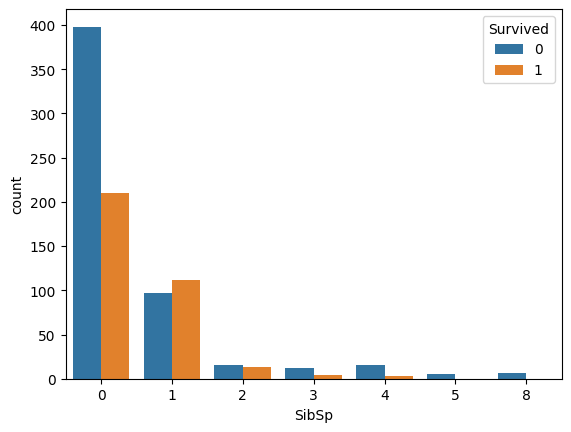

In [20]:
sns.countplot(data=data,x='SibSp',hue="Survived")

In [21]:
X.SibSp.value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

SibSp는 7개의 서로 다른 값을 가져서 one-hot encoding을 직접 하기엔 좋지 않아보임. 


In [22]:
ratio = np.round((X.SibSp>1).sum()/len(X.index)*100,decimals=1)
print("SibSp column에서 2 이상의 비율 = ",ratio,"%")

SibSp column에서 2 이상의 비율 =  8.3 %


대부분이 0~1이고, 2 이상은 적은 비율(8.3%)이기 때문에 값을 2 이상은 하나로 묶고 one-hot encoding을 진행.

In [23]:
X.SibSp.clip(upper=2,inplace=True)

one-hot encoding 결과

In [24]:
oh= pd.get_dummies(X.SibSp,prefix="SibSp")
X = X.drop(labels='SibSp',axis=1).join(oh)

In [25]:
X['SibSp_0']

PassengerId
1      False
2      False
3       True
4      False
5       True
       ...  
887     True
888     True
889    False
890     True
891     True
Name: SibSp_0, Length: 891, dtype: bool

### Parch (부모/자녀 수)

<Axes: xlabel='Parch', ylabel='count'>

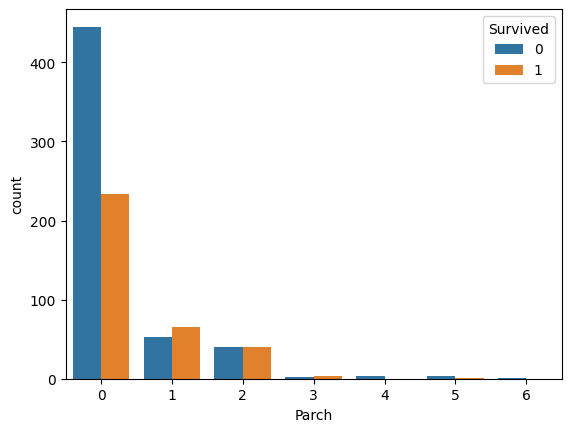

In [26]:
sns.countplot(data=data,x='Parch',hue="Survived")

In [27]:
X.Parch.value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

SibSp와 마찬가지로 2 이상을 하나의 category로 처리하고 one-hot encoding.


In [28]:
X.Parch.clip(upper=2,inplace=True)
oh= pd.get_dummies(X.Parch,prefix="Parch")
X = X.drop(labels='Parch',axis=1).join(oh)

### FamilySize (가족 크기 변수 생성)
Derived Variable(파생 변수)
>형제자매/배우자 수(SibSp)와 부모/자녀 수(Parch)를 합치고 자기 자신을 더해서 `FamilySize`라는 파생 변수를 만듦  
>
>가족과 함께 탑승했는지 여부가 생존에 영향을 줄 수 있으므로 추가

In [29]:
# FamilySize 파생 변수 생성
# SibSp와 Parch가 이미 원-핫 인코딩되어 있기 때문에 각각의 값을 곱해서 다시 합산해줌
X["FamilySize"] = (
    X.get("SibSp_1", 0) * 1 + X.get("SibSp_2", 0) * 2 +
    X.get("Parch_1", 0) * 1 + X.get("Parch_2", 0) * 2 + 1
)
X["FamilySize"] = X["FamilySize"].astype(float)  # 나중에 Tensor 변환 등을 고려하여 float 형변환
X["FamilySize"].head()

PassengerId
1    2.0
2    2.0
3    1.0
4    2.0
5    1.0
Name: FamilySize, dtype: float64

### Ticket (티켓 번호)

>의미 있는 정보 추출이 어렵고 중복도 많아서 과감히 제거!

In [30]:
X.drop(labels='Ticket',axis=1,inplace=True)

### Fare (요금)

/tmp/ipykernel_3085817/441118664.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data,x='Fare', shade=True,hue="Survived")


<Axes: xlabel='Fare', ylabel='Density'>

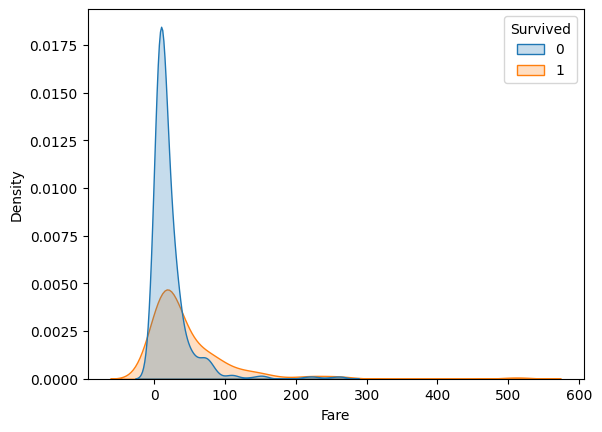

In [31]:
sns.kdeplot(data=data,x='Fare', shade=True,hue="Survived")

분포가 한쪽으로 치우쳐 있어 평균과 표준편차로 정규화(or 표준화)가 필요해 보임.

In [32]:
X.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

Standardization 진행
* 평균을 빼고 표준편차로 나누는 방식으로 스케일링. 

In [33]:
X.Fare = (X.Fare-X.Fare.mean())/X.Fare.std()

### Cabin (객실 번호)

결측치가 많지만, 존재 여부나 앞 문자 등은 정보가 될 수 있어서 전처리 후 유의미한 값만 남김.
* 결측치를 'U'로 대체해서 보자

In [34]:
X.Cabin[X.Cabin.isna()]='U'

/tmp/ipykernel_3085817/1686841740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.Cabin[X.Cabin.isna()]='U'


In [35]:
X.Cabin=X.Cabin.str[0] #select the first letter
X.Cabin.value_counts() #print the statistics

Cabin
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

<Axes: xlabel='Cabin', ylabel='count'>

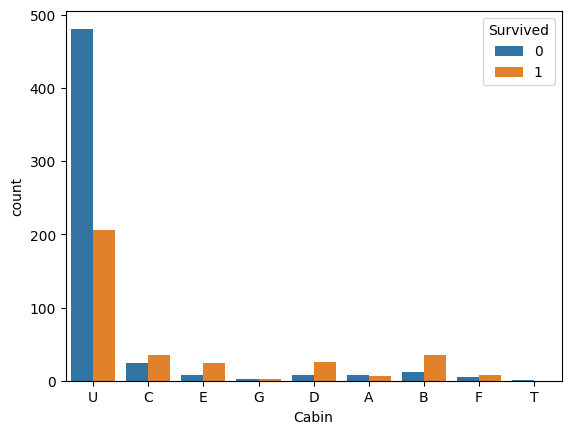

In [36]:
sns.countplot(data=data,x=X.Cabin,hue="Survived")

각 Cabin에 대해 Chi2 독립성 검정을 진행
* Cabin이라는 변수가 생존률(y)과 독립적인지(무관한지)를 통계적으로 검증
* 즉, 예측에 영향을 주는 변수인지 아닌지 보기 위해 검증

In [37]:
from scipy.stats import chi2_contingency
for letter in X.Cabin.unique():
    cab_binary = X.Cabin==letter
    contigency = pd.crosstab(cab_binary, y) 
    c, p, dof, expected = chi2_contingency(contigency)
    p = np.round(p*100,decimals=3)
    print('Chi2 test for the independence of Cabin = ',letter,'. p-value =',p,"%")
    

Chi2 test for the independence of Cabin =  U . p-value = 0.0 %
Chi2 test for the independence of Cabin =  C . p-value = 0.102 %
Chi2 test for the independence of Cabin =  E . p-value = 0.003 %
Chi2 test for the independence of Cabin =  G . p-value = 100.0 %
Chi2 test for the independence of Cabin =  D . p-value = 0.002 %
Chi2 test for the independence of Cabin =  A . p-value = 69.098 %
Chi2 test for the independence of Cabin =  B . p-value = 0.0 %
Chi2 test for the independence of Cabin =  F . p-value = 14.928 %
Chi2 test for the independence of Cabin =  T . p-value = 100.0 %


Cabin의 statistic과 plot을 통해 U가 결측치를 나타내는 가장 중요한 정보임을 알 수 있음

one-encoding을 진행하되 p-value가 낮은 G, A, F, T는 제거해서 진행

In [38]:
oh = pd.get_dummies(X.Cabin,prefix="Cabin")
categories_to_drop = ['Cabin_'+i for i in ['G','A','F','T']]
oh = oh.drop(labels = categories_to_drop, axis = 1) 

X = X.drop(labels='Cabin',axis=1).join(oh)

### Embarked (탑승 항구)

<Axes: xlabel='Embarked', ylabel='count'>

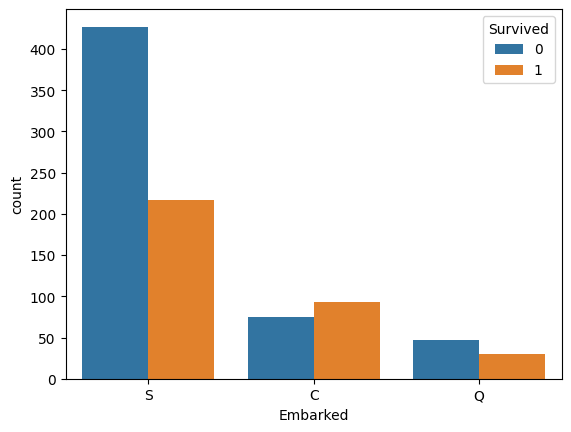

In [39]:
sns.countplot(data=data,x='Embarked',hue="Survived")

In [40]:
X.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

결측치는 최빈값으로 채우고 one-hot encoding.

In [41]:
oh= pd.get_dummies(X.Embarked,prefix="Embarked")
X = X.drop(labels='Embarked',axis=1).join(oh)

## feature engineering Summary

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           891 non-null    uint8  
 1   Age           891 non-null    float64
 2   Fare          891 non-null    float64
 3   Pclass_1      891 non-null    bool   
 4   Pclass_2      891 non-null    bool   
 5   Pclass_3      891 non-null    bool   
 6   Title_Master  891 non-null    bool   
 7   Title_Miss    891 non-null    bool   
 8   Title_Mr      891 non-null    bool   
 9   Title_Mrs     891 non-null    bool   
 10  Title_Rare    891 non-null    bool   
 11  SibSp_0       891 non-null    bool   
 12  SibSp_1       891 non-null    bool   
 13  SibSp_2       891 non-null    bool   
 14  Parch_0       891 non-null    bool   
 15  Parch_1       891 non-null    bool   
 16  Parch_2       891 non-null    bool   
 17  FamilySize    891 non-null    float64
 18  Cabin_B       891 non-null    bool 

In [43]:
X.corr()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Parch_2,FamilySize,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
Sex,1.000000,-0.084153,0.182333,0.098013,0.064746,-0.137143,-0.159934,0.693916,-0.867334,0.550146,...,0.201880,0.253826,0.109689,0.058649,0.079248,0.047003,-0.140391,0.082853,0.074115,-0.125722
Age,-0.084153,1.000000,0.091566,0.319916,0.006589,-0.281004,-0.377265,-0.249169,0.185900,0.164533,...,-0.199046,-0.286577,0.091394,0.113149,0.132319,0.117211,-0.233123,0.032024,-0.013855,-0.027121
Fare,0.182333,0.091566,1.000000,0.591711,-0.118557,-0.413333,0.010908,0.119518,-0.183766,0.107259,...,0.202590,0.258672,0.386297,0.364318,0.098878,0.053717,-0.482075,0.269335,-0.117216,-0.166603
Pclass_1,0.098013,0.319916,0.591711,1.000000,-0.288585,-0.626738,-0.084700,0.020348,-0.097288,0.093608,...,-0.008743,0.001863,0.417160,0.470749,0.291218,0.242675,-0.788773,0.296423,-0.155342,-0.170379
Pclass_2,0.064746,0.006589,-0.118557,-0.288585,1.000000,-0.565210,0.009903,-0.021903,-0.088569,0.119193,...,-0.014539,0.009191,-0.120386,-0.135851,-0.041325,-0.038864,0.172413,-0.125416,-0.127301,0.192061
Pclass_3,-0.137143,-0.281004,-0.413333,-0.626738,-0.565210,1.000000,0.064918,0.000293,0.155907,-0.177658,...,0.019365,-0.009086,-0.261450,-0.295036,-0.217282,-0.177461,0.539291,-0.153329,0.237449,-0.009511
Title_Master,-0.159934,-0.377265,0.010908,-0.084700,0.009903,0.064918,1.000000,-0.110981,-0.254903,-0.087987,...,0.206088,0.382476,-0.026914,-0.035937,-0.042519,-0.012717,0.027841,-0.035225,0.010478,0.025291
Title_Miss,0.693916,-0.249169,0.119518,0.020348,-0.021903,0.000293,-0.110981,1.000000,-0.601857,-0.207749,...,0.145912,0.124744,0.064880,0.008343,0.016822,0.020161,-0.043749,0.036204,0.167531,-0.140414
Title_Mr,-0.867334,0.185900,-0.183766,-0.097288,-0.088569,0.155907,-0.254903,-0.601857,1.000000,-0.477160,...,-0.266175,-0.394009,-0.114673,-0.047873,-0.049952,-0.031384,0.137319,-0.072567,-0.078338,0.118482
Title_Mrs,0.550146,0.164533,0.107259,0.093608,0.119193,-0.177658,-0.087987,-0.207749,-0.477160,1.000000,...,0.110266,0.206390,0.062731,0.073270,0.073907,0.042837,-0.123817,0.067872,-0.090432,-0.007704


## Feature scoring

> 각 feature가 Survived에 얼마나 영향을 주는지 Mutal Information Score로 측정하고 시각화함.

<Axes: xlabel='MI Scores', ylabel='None'>

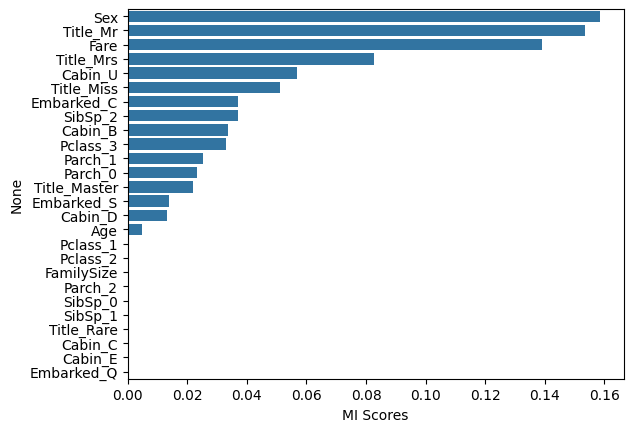

In [44]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    discrete_features = [X.columns.get_loc(column_name) for column_name in X.dtypes[X.dtypes=='uint8'].index] 
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

    
  
mi_scores = make_mi_scores(X, y)
X = X[mi_scores.index]  
sns.barplot(x=mi_scores, y=mi_scores.index)


## Splitting
Train과 validation 분류

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=1,shuffle=True)

# Metric : Accuracy, F1-score, ROC-AUC

`Accuracy` 이외에도 `F1-score`와 `ROC-AUC`를 계산해 모델의 precision·recall 균형과 전체 분류 성능을 확인.


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(name, y_true, y_pred, y_proba=None):
    print(f"📌 {name} 결과:")
    print("  - Accuracy :", accuracy_score(y_true, y_pred))
    print("  - Precision:", precision_score(y_true, y_pred))
    print("  - Recall   :", recall_score(y_true, y_pred))
    print("  - F1 Score :", f1_score(y_true, y_pred))
    if y_proba is not None:
        print("  - ROC AUC  :", roc_auc_score(y_true, y_proba))
    print("-" * 40)


### Models
기본 모델: `Logistic Regression`, `Decision Tree`

개선 모델: `Random Forest`, `XGBoost`

딥러닝: `Simple MLP model` 

In [47]:
# train/val split 이후의 전체 feature를 사용
# feature를 select해서 사용해도 무방하나 feature selection 과정을 추가로 넣어야 함 (MI를 기준으로 해도 됨)
all_features = X.columns.tolist()

Logistic Regression, Decision Tree, Random Forest, XGBoost

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=0)
}

for name, model in models.items():
    model.fit(X_train[all_features], y_train)
    y_pred = model.predict(X_val[all_features])

    # 확률 값이 있을 경우 ROC-AUC도 평가
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val[all_features])[:, 1]
    else:
        y_proba = None

    evaluate_model(name, y_val, y_pred, y_proba)


/home/icl/anaconda3/envs/ML/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


📌 Logistic Regression 결과:
  - Accuracy : 0.7988826815642458
  - Precision: 0.7761194029850746
  - Recall   : 0.7123287671232876
  - F1 Score : 0.7428571428571429
  - ROC AUC  : 0.8252132333936417
----------------------------------------
📌 Decision Tree 결과:
  - Accuracy : 0.7262569832402235
  - Precision: 0.6764705882352942
  - Recall   : 0.6301369863013698
  - F1 Score : 0.652482269503546
  - ROC AUC  : 0.7104548979064358
----------------------------------------
📌 Random Forest 결과:
  - Accuracy : 0.776536312849162
  - Precision: 0.7894736842105263
  - Recall   : 0.6164383561643836
  - F1 Score : 0.6923076923076923
  - ROC AUC  : 0.8233393641767899
----------------------------------------
📌 XGBoost 결과:
  - Accuracy : 0.770949720670391
  - Precision: 0.7857142857142857
  - Recall   : 0.6027397260273972
  - F1 Score : 0.6821705426356588
  - ROC AUC  : 0.8409795812871542
----------------------------------------


### 딥러닝 모델
Simple MLP 사용

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Tensor 변환
X_tr = torch.tensor(X_train[all_features].astype(float).values, dtype=torch.float32)
y_tr = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_vl = torch.tensor(X_val[all_features].astype(float).values, dtype=torch.float32)
y_vl = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_tr, y_tr)
val_ds   = TensorDataset(X_vl, y_vl)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleMLP(len(all_features)).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = criterion(model(xb), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 검증
model.eval()
y_pred_list = []
y_proba_list = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        out = model(xb).cpu()
        y_proba_list.append(out)
        y_pred_list.append((out > 0.5).float())

y_pred_mlp = torch.cat(y_pred_list).numpy().flatten()
y_proba_mlp = torch.cat(y_proba_list).numpy().flatten()

evaluate_model("MLP (PyTorch, all features)", y_val.values, y_pred_mlp, y_proba_mlp)


📌 MLP (PyTorch, all features) 결과:
  - Accuracy : 0.7262569832402235
  - Precision: 0.7608695652173914
  - Recall   : 0.4794520547945205
  - F1 Score : 0.5882352941176471
  - ROC AUC  : 0.8097053502196951
----------------------------------------


#### 한눈에 비교하기!

In [50]:
# MLP
evaluate_model("MLP (PyTorch, all features)", y_val.values, y_pred_mlp, y_proba_mlp)
# Logistic Regression, Decision Tree, Random Forest, XGBoost
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=0)
}

for name, model in models.items():
    model.fit(X_train[all_features], y_train)
    y_pred = model.predict(X_val[all_features])

    # 확률 값이 있을 경우 ROC-AUC도 평가
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val[all_features])[:, 1]
    else:
        y_proba = None

    evaluate_model(name, y_val, y_pred, y_proba)

📌 MLP (PyTorch, all features) 결과:
  - Accuracy : 0.7262569832402235
  - Precision: 0.7608695652173914
  - Recall   : 0.4794520547945205
  - F1 Score : 0.5882352941176471
  - ROC AUC  : 0.8097053502196951
----------------------------------------
📌 Logistic Regression 결과:
  - Accuracy : 0.7988826815642458
  - Precision: 0.7761194029850746
  - Recall   : 0.7123287671232876
  - F1 Score : 0.7428571428571429
  - ROC AUC  : 0.8252132333936417
----------------------------------------
📌 Decision Tree 결과:
  - Accuracy : 0.7262569832402235
  - Precision: 0.6764705882352942
  - Recall   : 0.6301369863013698
  - F1 Score : 0.652482269503546
  - ROC AUC  : 0.7104548979064358
----------------------------------------
📌 Random Forest 결과:
  - Accuracy : 0.776536312849162


/home/icl/anaconda3/envs/ML/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


  - Precision: 0.7894736842105263
  - Recall   : 0.6164383561643836
  - F1 Score : 0.6923076923076923
  - ROC AUC  : 0.8233393641767899
----------------------------------------
📌 XGBoost 결과:
  - Accuracy : 0.770949720670391
  - Precision: 0.7857142857142857
  - Recall   : 0.6027397260273972
  - F1 Score : 0.6821705426356588
  - ROC AUC  : 0.8409795812871542
----------------------------------------
